In [ ]:
import os
import time
import uuid
import cv2
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt
import albumentations as alb
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import load_model


In [ ]:
'''IMAGES_PATH = os.path.join('data','images')
number_images = 30'''

In [ ]:
'''cap = cv2.VideoCapture(1)
for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read()
    imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()'''

error: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\imgcodecs\src\loadsave.cpp:798: error: (-215:Assertion failed) !_img.empty() in function 'cv::imwrite'


In [12]:
!labelme

2024-12-29 18:41:23,113 [INFO   ] __init__:get_config:67- Loading config file from: C:\Users\1234\.labelmerc


In [ ]:
'''# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)'''

In [ ]:
#tf.config.list_physical_devices('CPU')

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [ ]:
#images = tf.data.Dataset.list_files('data\\images\\*.jpg')

In [ ]:
#images.as_numpy_iterator().next()

b'data\\images\\WIN_20241229_18_31_30_Pro.jpg'

In [3]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [ ]:
#images = images.map(load_image)

In [ ]:
#images.as_numpy_iterator().next()

array([[[145, 165, 190],
        [158, 176, 200],
        [138, 154, 177],
        ...,
        [107, 117, 127],
        [108, 118, 128],
        [108, 118, 127]],

       [[152, 172, 197],
        [156, 176, 200],
        [134, 150, 173],
        ...,
        [108, 118, 128],
        [109, 119, 129],
        [109, 119, 128]],

       [[134, 156, 179],
        [140, 161, 182],
        [130, 147, 167],
        ...,
        [110, 118, 129],
        [110, 118, 129],
        [111, 120, 129]],

       ...,

       [[ 49,  49,  59],
        [ 50,  50,  60],
        [ 51,  51,  61],
        ...,
        [ 83,  88,  94],
        [ 81,  88,  94],
        [ 80,  87,  93]],

       [[ 51,  50,  58],
        [ 50,  50,  58],
        [ 51,  51,  59],
        ...,
        [ 84,  89,  95],
        [ 83,  88,  94],
        [ 83,  88,  94]],

       [[ 52,  51,  57],
        [ 52,  51,  57],
        [ 52,  52,  60],
        ...,
        [ 84,  89,  95],
        [ 84,  89,  95],
        [ 83,  88,  94]]

In [ ]:
#type(images)

tensorflow.python.data.ops.dataset_ops.MapDataset

In [ ]:
#image_generator = images.batch(4).as_numpy_iterator()

In [ ]:
#plot_images = image_generator.next()

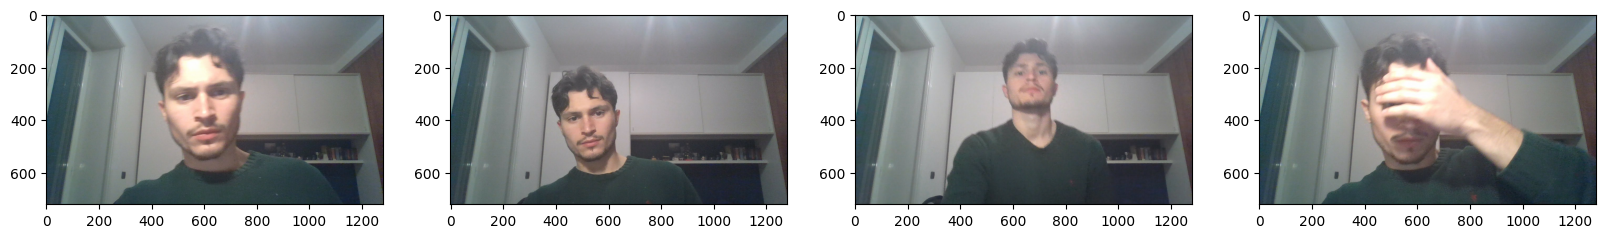

In [ ]:
'''fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()'''

In [41]:
90*.7 # 63 to train

62.99999999999999

In [42]:
90*.15 # 14 and 13 to test and val

13.5

In [44]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)   

In [3]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

In [4]:
img = cv2.imread(os.path.join('data','train', 'images','WIN_20241229_18_31_30_Pro.jpg'))

In [5]:
print(img.shape)

(720, 1280, 3)


In [6]:
with open(os.path.join('data', 'train', 'labels', 'WIN_20241229_18_31_30_Pro.json'), 'r') as f:
    label = json.load(f)

In [7]:
label['shapes'][0]['points']

[[370.7692307692308, 190.76923076923077],
 [697.6923076923076, 575.3846153846155]]

In [8]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [9]:
coords

[370.7692307692308, 190.76923076923077, 697.6923076923076, 575.3846153846155]

In [10]:
coords = list(np.divide(coords, [1280,720,1280,720]))

In [11]:
coords

[0.28966346153846156,
 0.26495726495726496,
 0.5450721153846153,
 0.7991452991452993]

In [12]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [13]:
augmented['bboxes'][0][2:]

(0.7370940170940169, 1.0)

In [14]:
augmented['bboxes']

[(0.010598290598290734, 0.37948717948717947, 0.7370940170940169, 1.0)]

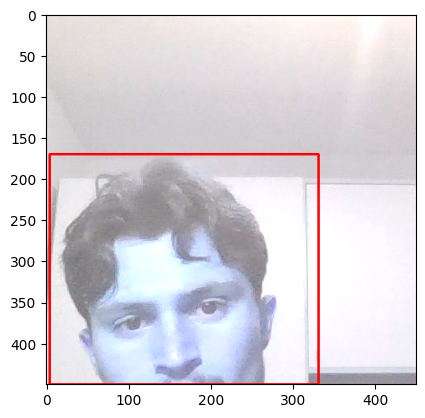

In [15]:
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)), 
                    (255,0,0), 2)

plt.imshow(augmented['image'])

In [16]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [1280,720,1280,720]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

y_max is less than or equal to y_min for bbox [0.4128605769230769, 0.9754273504273505, 0.7163461538461539, 0.5534188034188035, 'face'].


In [4]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [5]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [6]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [7]:
train_images.as_numpy_iterator().next()

array([[[0.5710784 , 0.5632353 , 0.575     ],
        [0.57254905, 0.5647059 , 0.5764706 ],
        [0.57254905, 0.5647059 , 0.5764706 ],
        ...,
        [0.5816789 , 0.5816789 , 0.5738358 ],
        [0.5828431 , 0.5828431 , 0.5897059 ],
        [0.5744485 , 0.5719975 , 0.5871936 ]],

       [[0.5686275 , 0.54901963, 0.5647059 ],
        [0.57254905, 0.5529412 , 0.5686275 ],
        [0.5764706 , 0.5568628 , 0.57254905],
        ...,
        [0.5765319 , 0.57555145, 0.56917894],
        [0.57604164, 0.57506126, 0.5824142 ],
        [0.5790441 , 0.5780637 , 0.58639705]],

       [[0.56832105, 0.5487132 , 0.5643995 ],
        [0.5651961 , 0.54558825, 0.5612745 ],
        [0.56911767, 0.5495098 , 0.5651961 ],
        ...,
        [0.5803922 , 0.57254905, 0.5764706 ],
        [0.5716299 , 0.56378675, 0.5745711 ],
        [0.5683824 , 0.5605392 , 0.57230395]],

       ...,

       [[0.626348  , 0.61066175, 0.60968137],
        [0.62444854, 0.60876226, 0.61268383],
        [0.6279412 , 0

In [8]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

In [9]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [10]:
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [11]:
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [12]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.2448, 0.1353, 0.9287, 1.    ], dtype=float16))

In [13]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(3780, 3780, 780, 780, 780, 780)

In [14]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [15]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [16]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [17]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [0],
        [0],
        [1],
        [1],
        [0],
        [0],
        [1]], dtype=uint8),
 array([[0.581 , 0.0706, 1.    , 1.    ],
        [0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    ],
        [0.5415, 0.2922, 1.    , 1.    ],
        [0.399 , 0.    , 1.    , 0.7305],
        [0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    ],
        [0.588 , 0.    , 1.    , 0.943 ]], dtype=float16))

In [18]:
data_samples = train.as_numpy_iterator()

In [19]:
res = data_samples.next()

In [ ]:
'''fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    sample_image = sample_image.copy()
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)'''

'fig, ax = plt.subplots(ncols=4, figsize=(20,20))\nfor idx in range(4): \n    sample_image = res[0][idx]\n    sample_coords = res[1][1][idx]\n    \n    cv2.rectangle(sample_image, \n                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),\n                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), \n                        (255,0,0), 2)\n\n    ax[idx].imshow(sample_image)'

In [21]:
vgg = VGG16(include_top=False)

In [23]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [24]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

In [25]:
facetracker = build_model()

In [26]:
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_2[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d (GlobalMa  (None, 512)         0           ['vgg16[0][0]']                  
 xPooling2D)                                                                                  

In [27]:
X, y = train.as_numpy_iterator().next()

In [28]:
X.shape

(8, 120, 120, 3)

In [29]:
classes, coords = facetracker.predict(X)

In [30]:
classes, coords

(array([[0.4566493 ],
        [0.42629275],
        [0.4419263 ],
        [0.3969202 ],
        [0.38020024],
        [0.41479272],
        [0.43866292],
        [0.45798266]], dtype=float32),
 array([[0.38304278, 0.4980205 , 0.51976806, 0.40360633],
        [0.3994133 , 0.48210448, 0.514611  , 0.33805338],
        [0.41349375, 0.4277019 , 0.48631114, 0.36903155],
        [0.40888226, 0.45648113, 0.4876648 , 0.35776   ],
        [0.41416004, 0.43302003, 0.49945334, 0.3408335 ],
        [0.32410258, 0.51190543, 0.48672718, 0.44453484],
        [0.298618  , 0.5127861 , 0.49792233, 0.379106  ],
        [0.32516026, 0.54363334, 0.55959404, 0.4450763 ]], dtype=float32))

In [31]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [32]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)

In [33]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [34]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

In [35]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=6.4838977>

In [36]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.67396593>

In [37]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=6.4838977>

In [38]:
class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [39]:
model = FaceTracker(facetracker)

In [40]:
model.compile(opt, classloss, regressloss)

In [41]:
logdir='logs'

In [42]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [43]:
hist = model.fit(train, epochs=5, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/5
473/473 [==============================] - 985s 2s/step - total_loss: 1.3504 - class_loss: 0.3154 - regress_loss: 1.1927 - val_total_loss: 0.5483 - val_class_loss: 0.4139 - val_regress_loss: 0.3414
Epoch 2/5
473/473 [==============================] - 990s 2s/step - total_loss: 0.5987 - class_loss: 0.1648 - regress_loss: 0.5162 - val_total_loss: 0.0911 - val_class_loss: 0.0622 - val_regress_loss: 0.0600
Epoch 3/5
473/473 [==============================] - 918s 2s/step - total_loss: 0.4501 - class_loss: 0.1290 - regress_loss: 0.3855 - val_total_loss: 0.0911 - val_class_loss: 0.0321 - val_regress_loss: 0.0750
Epoch 4/5
473/473 [==============================] - 919s 2s/step - total_loss: 0.4100 - class_loss: 0.1159 - regress_loss: 0.3521 - val_total_loss: 0.0279 - val_class_loss: 0.0126 - val_regress_loss: 0.0216
Epoch 5/5
473/473 [==============================] - 922s 2s/step - total_loss: 0.3161 - class_loss: 0.0920 - regress_loss: 0.2701 - val_total_loss: 1.5485 - val_class_

In [44]:
hist.history

{'total_loss': [0.15489575266838074,
  0.054058950394392014,
  0.06657630205154419,
  0.02987055853009224,
  0.013079585507512093],
 'class_loss': [0.11574937403202057,
  0.04215095937252045,
  0.05171698331832886,
  0.025201907381415367,
  0.0002995652030222118],
 'regress_loss': [0.09702107310295105,
  0.03298347070813179,
  0.04071781039237976,
  0.01726960577070713,
  0.012929802760481834],
 'val_total_loss': [0.5482908487319946,
  0.09107324481010437,
  0.09111462533473969,
  0.027901221066713333,
  1.5484589338302612],
 'val_class_loss': [0.41387733817100525,
  0.06220515817403793,
  0.032139986753463745,
  0.012597156688570976,
  1.0962915420532227],
 'val_regress_loss': [0.3413521647453308,
  0.0599706694483757,
  0.07504463195800781,
  0.02160264179110527,
  1.00031316280365]}

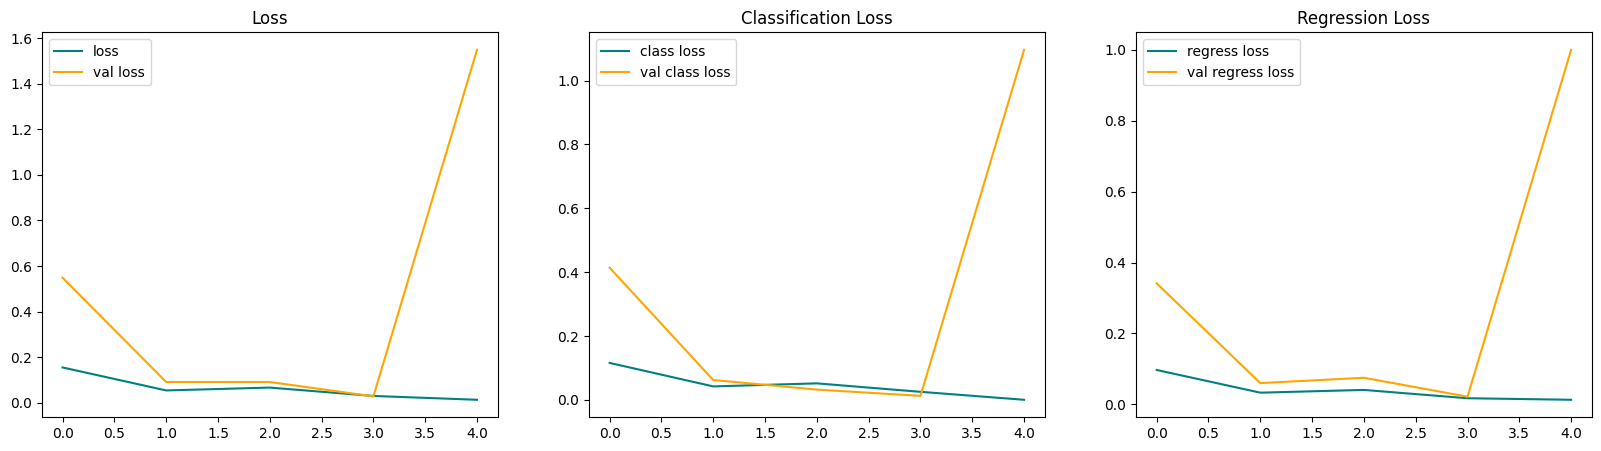

In [45]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

In [46]:
test_data = test.as_numpy_iterator()

In [47]:
test_sample = test_data.next()

In [48]:
yhat = facetracker.predict(test_sample[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


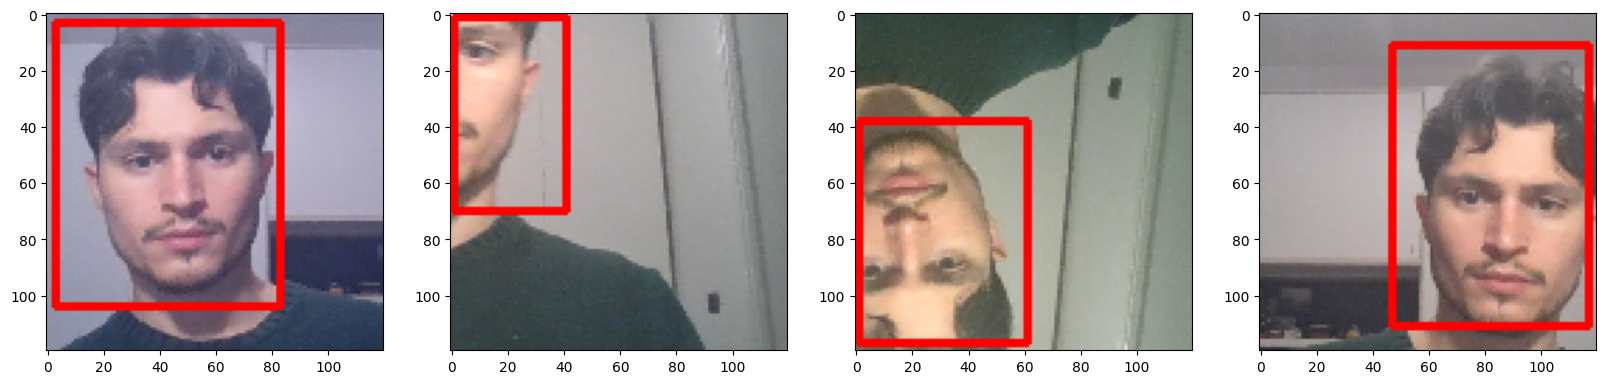

In [50]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        sample_image = sample_image.copy()
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

## Save the model

In [54]:
facetracker.save('facetracker.h5')

In [55]:
facetracker = load_model('facetracker.h5')

In [56]:
# Real time detection

cap = cv2.VideoCapture(1)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

error: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\highgui\src\window.cpp:1295: error: (-2:Unspecified error) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Cocoa support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function 'cvDestroyAllWindows'
